In [1]:
cd(@__DIR__)
include("setup.jl")
import Pkg; Pkg.activate(@__DIR__)
using Logging, DelimitedFiles, Random, LinearAlgebra, Statistics
using CairoMakie
using HiddenDynamicsInference
blues =  [colorant"#3E4756", colorant"#A2ACBD", colorant"#7493BC", colorant"#2271B2", colorant"#72AFF5", colorant"#EFFAFF"]
greens =  [colorant"#384B42", colorant"#9BB0A5", colorant"#659C82", colorant"#359B73", colorant"#ABD07A", colorant"#E8FFF3"]

  Activating project at `~/Dropbox (MIT)/Research/NonlinearOscillators/HiddenDynamicsInference/examples`


In [4]:
# Parameters for the notebook
numflds = 2 # Total number of equations in the model 
numvars = 1 # Number of observed fields
data_window = 141:375 #Window to crop data to ~3 oscillations
# Amount of noise to add to the data
noise_level = 10
# Random seed for reproducibility
rng = MersenneTwister(1111)
# Tolerances for the ODE solutions
reltol = 1e-6
abstol = 1e-8
# Whether to run the sweeps. WARNING these can take hours
RUNSWEEPS = false

true

# Hidden Dynamics Inference - FHN
1. Start by simulating some noisy data and cropping to the training window

In [5]:
# Simulate test data
truep = vcat([0.5, 1.0, -1.0, 0.0, 0.0, 0.0, -1/3, 0.0, 0.0, 0.0], [0.7, 1.0, -0.8, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0] / 12.5 )
tspan = (0.0, 250.0)
function fhn_odefun!(du, u, p, t)
    du[1] = 0.5 + u[1] - u[2] - u[1]^3/3
    du[2] = (0.7 + u[1] - 0.8 * u[2])/12.5
end
prob = ODEProblem(fhn_odefun!, [1.0, 1.0], tspan)
truedata = solve(prob, Tsit5(), saveat = 0.5, abstol = 1e-14, reltol = 1e-14)
truep = [truedata[:, data_window[1]]; normalize(truep[1:10]); normalize(truep[11:20]); norm(truep[1:10]); norm(truep[11:20])]

# add noise to the data
fulldata = truedata[1:numvars, :] + noise_level / 100 * std(truedata[1:numvars, :], dims = 2) .* randn(rng, numvars, size(truedata, 2))
data = fulldata[:, data_window]
t = truedata.t[data_window] .-  truedata.t[data_window[1]]
fulldata = fulldata[:, data_window[1]:end]
fullt = truedata.t[data_window[1]:end] .-  truedata.t[data_window[1]]

println("Data loss with true FHN: $(sum(abs2, data - truedata[1:numvars, data_window]) / (numvars * length(data_window)))")

Data loss with true FHN: 0.015262412053085749


# 2/3. Optimization sweep 

In [4]:
if RUNSWEEPS
# Sweep parameters
reps = 50
sweep_lambdas = [0.005, 0.01] # Add additional lambdas here
degrees = [[3, 3], ] # Add additional degree combinations e.g. linear cubic (1, 3) to the vector 

# Preallocate storage for the sweeps
params = Vector{Float64}[]
train_losses = Float64[]
train_delay_losses = Float64[]
test_delay_losses = Float64[]
degrees1 = Int64[]
degrees2 = Int64[]
lambdas = Float64[]

# Sweep 
disable_logging(Logging.Warn)
for degree in degrees
    HDIprob = PolynomialHiddenDynamicsInferenceProblem(powgenerate(numflds, degree), t, data)
    for lambda = sweep_lambdas
        for rep = 1:reps
            push!(lambdas, lambda); push!(degrees1, degree[1]); push!(degrees2, degree[2])
            # Randomly initalize a suitable parameter vector for the problem 
            p0 = randinit(HDIprob)
            # Optimize the parameters
            optp, optval = HiddenDynamicsInference.optimize(HDIprob, p0, lambda = lambda, showprogress = false)
            # Center and scale the coefficients 
            center_coefficients!(HDIprob, optp, 2)
            std_scale_coefficients!(HDIprob, optp, 2)
            # map_coefficients(optp, HDIprob.pows, refpows)
            push!(params, optp)
            # Calculate the train loss
            train_loss = dataloss(HDIprob, optp, 1; verbose = false, reltol = reltol, abstol = abstol)
            push!(train_losses, train_loss)
            # Search for the limit cycle
            train_delay_loss, test_delay_loss, desc_str = find_limit_cycle(HDIprob, optp, fullt, verbose = false, fulldata, abstol = abstol)
            push!(train_delay_losses, train_delay_loss)
            push!(test_delay_losses,  test_delay_loss)
            print(stdout, "$(rep) - $(optval), "); flush(stdout)
        end
    end
end
HDIprob = PolynomialHiddenDynamicsInferenceProblem(powgenerate(2, 3), t, data)
else
HDIprob = PolynomialHiddenDynamicsInferenceProblem(powgenerate(2, 3), t, data)
sweepcsv, sweepheader = readdlm("fhn_2D_noise10_sweep_results.csv", '\t', header = true)
degrees1 = Int64.(sweepcsv[:, 1])
degrees2 = Int64.(sweepcsv[:, 2])
lambdas  = Float64.(sweepcsv[:, 3])
train_losses = Float64.(sweepcsv[:, 4])
train_delay_losses = Float64.(sweepcsv[:, 5])
test_delay_losses = Float64.(sweepcsv[:, 6])
parammat = sweepcsv[:, 7:end];
parammat[isnan.(parammat)] .= 0.0 
params = Vector{Float64}.(collect(eachrow(parammat)));
nothing
end

50 - 0.03002202944728826), 

50 - 0.12222125367792341), 

50 - 1.3449502065004402), 

# 4/5. Automatically filter models

In [10]:
# Only keep models with limit cycles and finite losses
filtered_train_losses = train_losses[.!isnan.(train_delay_losses)]
filtered_train_losses = filtered_train_losses[isfinite.(filtered_train_losses)]
# Set the good model threshold by fitting a Kernel Density Estimate 
train_loss_thresh, kde_fit = calculate_KDEthresh(filtered_train_losses)
good_model_inds = findall((train_losses .< train_loss_thresh) .& (.!isnan.(train_delay_losses)));
println("Number of good models kept is $(length(good_model_inds))")

Number of good models kept is 4239


# 6-8. Model distance matrix

In [11]:
# Calculate the parameter matrix multiplying back by tau
cumsplits = [0; cumsum(HDIprob.splits)...]
coeffmat = hcat(params[good_model_inds]...)[numflds + 1:end, :] # crop the ICs 
for i = 1:numflds
    # Rescale by tau 
    coeffmat[cumsplits[i] + 1:cumsplits[i + 1], :] .*= coeffmat[end - numflds + i, :]' 
end
coeffmat = coeffmat[1:cumsplits[end], :]

# Compute distance matrix between all good models
Dcoeffs, coeffmat_symms, linear_transforms, best_symm = compute_model_distances(coeffmat, HDIprob.pows; numobs=numvars, signflip=true, permute=false)

# Cluster the distance matrix
result = hclust(Dcoeffs; linkage=:single, branchorder=:optimal);

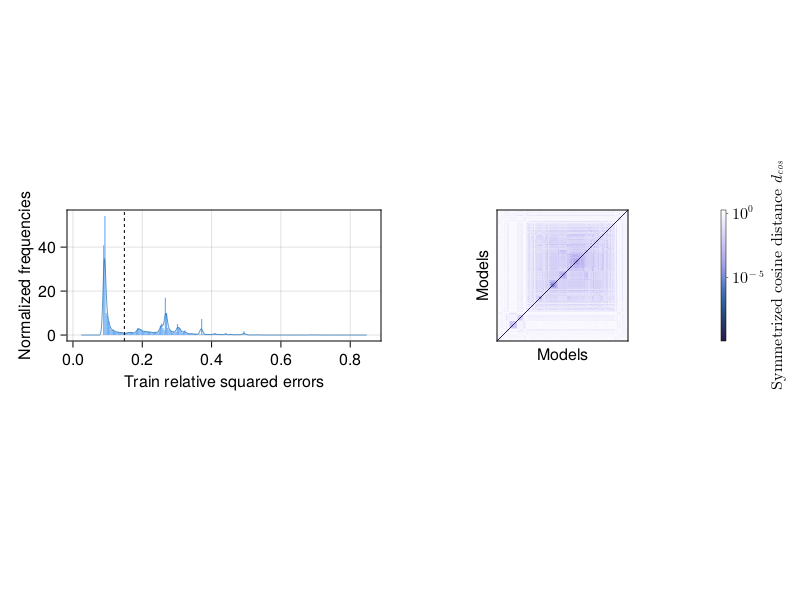

CairoMakie.Screen{IMAGE}


In [12]:
fig = Figure()
ax = Axis(fig[1, 1])
hist!(ax, filtered_train_losses, bins=200, normalization=:pdf, color=blues[5])
lines!(ax, kde_fit.x, kde_fit.density, color=(blues[4], 0.7), linewidth=1)
vlines!(ax, train_loss_thresh, color=:black, linestyle=:dash, linewidth=1)
ax.xlabel = "Train relative squared errors"
ax.ylabel = "Normalized frequencies"

ax = Axis(fig[1, 2], aspect=1)
hm = heatmap!(ax, log10.(Dcoeffs[result.order, result.order]), colormap=:devon)
Colorbar(fig[1, 3], hm, label=Makie.latexstring("Symmetrized cosine distance \$d_{cos}\$"), width=5, height=131, ticksize=2, spinewidth=0.5, tickwidth=0.5, ticks=([-10, -5, 0], [L"10^{-10}", L"10^{-5}", L"10^0"]))
hidedecorations!(ax, label = false)
ax.xlabel = "Models"; ax.ylabel = "Models"
colgap!(fig.layout, 1)
display(fig)

# 9 - 11. Model Clustering

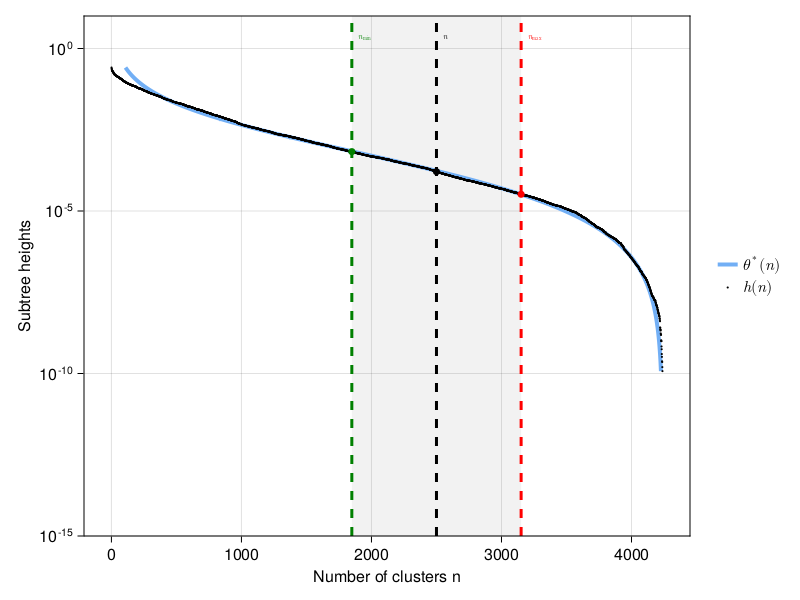

CairoMakie.Screen{IMAGE}


In [18]:
# Perform heirarchical clustering and inspect clusters at a range of cutoffs
rng = MersenneTwister(2222)
kmin, Dmin, kmax, Dmax, hierarchical_clustering, fit_height_curve = hierarchical_clustering_range(Dcoeffs; rng=rng)
kmid = floor(Int64, (kmin+kmax)/2)
Dmid = HiddenDynamicsInference.k_to_h(result, kmid)

# Plotting 
fig = Figure()
ax = Axis(fig[1, 1], yscale=log10)
heights = reverse(result.heights); heights = heights[heights .> 0]
poly!(ax, Rect(kmin, 1e-18, kmax-kmin, 1e3), color = (:gray, 0.1))
lin = lines!(ax, fit_height_curve, heights; linewidth=4, color=blues[5])
sca = scatter!(ax, 1:length(heights), heights, color=:black, markersize=3)
scatter!(ax, kmin, Dmax, color="green", markersize=10)
scatter!(ax, kmid, Dmid, color=:black, markersize=10)
scatter!(ax, kmax, Dmin, color="red", markersize=10)
text!(ax, kmin+50, 3; text=L"n_\text{min}", fontsize=8, color="green", align=(:left, :top))
text!(ax, kmid+50, 3; text=L"n", fontsize=8, color=:black, align=(:left, :top))
text!(ax, kmax+50, 3; text=L"n_\text{max}", fontsize=8, color="red", align=(:left, :top))
vlines!(ax, kmin, linestyle=:dash, linewidth=3, color="green")
vlines!(ax, kmid, linestyle=:dash, linewidth=3, color=:black)
vlines!(ax, kmax, linestyle=:dash, linewidth=3, color="red")
ylims!(ax, 1e-15, 1e1)
ax.xlabel="Number of clusters n"
ax.ylabel="Subtree heights"
Legend(fig[1, 2], [lin, sca], [L"\theta^*(n)", L"h(n)"]; width=70, height=50, framevisible=false)
display(fig)

# 12-14. Model ranking

In [14]:
# Rank model terms using coefficient of variation at several different cutoffs
coeff_ranks, term_pos_counts = coeff_var_ranking(hierarchical_clustering, kmin, kmax; coeffmat_symms=coeffmat_symms, best_symm=best_symm)

216 / 4239


([6 6 … 6 6; 3 3 … 2 2; … ; 15 15 … 19 19; 14 14 … 20 20], [0.0 0.0 … 0.0 0.0; 878.0 325.0 … 0.0 0.0; … ; 0.0 0.0 … 1202.0 0.0; 0.0 0.0 … 0.0 1202.0])

In [15]:
# Average these rankings with the Kemeny-Young algorithm
aggr_rank, opt_X, obj_val = kemeny_young(coeff_ranks)
eqstrs = pow2strs(HDIprob.pows, ["v", "w"])
for (i, trm) = enumerate(eqstrs[sortperm(aggr_rank)])
    println("Rank $(i) term -- " * trm)
end

Rank 1 term -- Eq.1: v³
Rank 2 term -- Eq.1: 1
Rank 3 term -- Eq.1: v²
Rank 4 term -- Eq.1: v²w
Rank 5 term -- Eq.2: 1
Rank 6 term -- Eq.2: v
Rank 7 term -- Eq.1: w
Rank 8 term -- Eq.2: w²
Rank 9 term -- Eq.2: v²
Rank 10 term -- Eq.1: w³
Rank 11 term -- Eq.1: vw
Rank 12 term -- Eq.1: v
Rank 13 term -- Eq.1: w²
Rank 14 term -- Eq.1: vw²
Rank 15 term -- Eq.2: vw
Rank 16 term -- Eq.2: w
Rank 17 term -- Eq.2: v³
Rank 18 term -- Eq.2: v²w
Rank 19 term -- Eq.2: vw²
Rank 20 term -- Eq.2: w³
